# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [2]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [3]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")

The file is created as expected.

In [4]:
%%bash
ls

cifar.tar.gz
starter-all-cifar.ipynb


### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [5]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [6]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [7]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [8]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [9]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [10]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

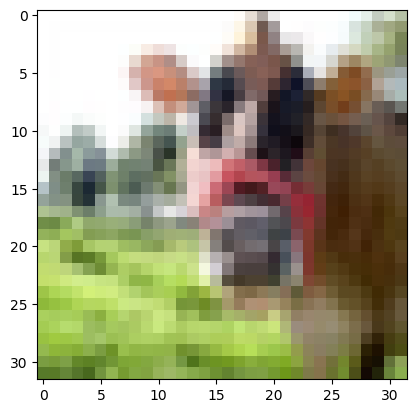

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(test_image)

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [12]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [13]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [14]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [15]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [16]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [17]:
import pandas as pd

# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
bicycle_label = dataset_meta[b'fine_label_names'].index(b'bicycle')
motorcycle_label = dataset_meta[b'fine_label_names'].index(b'motorcycle')

print(f"Bicycle label: {bicycle_label}\nMotorcycle label: {motorcycle_label}")

Bicycle label: 8
Motorcycle label: 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [18]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
# ATTENTION: NOT DONE HERE SINCE WE WANT TO TRAIN ON ALL OF CIFAR
# df_train = df_train[df_train["labels"].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
# ATTENTION: NOT DONE HERE SINCE WE WANT TO TRAIN ON ALL OF CIFAR
# df_test = df_test[df_test["labels"].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [19]:
!mkdir ./train
!mkdir ./test

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [20]:
save_response = "Error: could not save"
save_response_2 = "Success: saved "
if "Error" in save_response:
    print(save_response)
if "Error" in save_response_2:
    print(save_response_2)

Error: could not save


In [21]:
def save_images(output_path, dataset, data_row):
    #Grab the image data in row-major form
    img = dataset[b'data'][data_row.row]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
    ))
    
    # Save the image
    try:
        plt.imsave(output_path+"/"+data_row['filenames'], target)
    except Exception as e:
        return f"Error: could not save {row.filenames}\n{e}"
    # Return any signal data you want for debugging
    return f"Success: saved {row.filenames} in {output_path}"
    
    
train_count = 0
test_count = 0
## TODO: save ALL images using the save_images function
# only print error in this case - otherwise the output will be far too long
for i, row in df_train.iterrows():
    save_response = save_images("./train", dataset_train, row)
    train_count += 1
    if train_count % 5000 == 0:
        print(f"Saved train image {int(train_count/1000)}k/50k")
    if "Error" in save_response:
        print(save_response)
for i, row in df_test.iterrows():
    save_response = save_images("./test", dataset_test, row)
    test_count += 1
    if test_count % 1000 == 0:
        print(f"Saved test image {int(test_count/1000)}k/10k")
    if "Error" in save_response:
        print(save_response)

Saved train image 5k/50k
Saved train image 10k/50k
Saved train image 15k/50k
Saved train image 20k/50k
Saved train image 25k/50k
Saved train image 30k/50k
Saved train image 35k/50k
Saved train image 40k/50k
Saved train image 45k/50k
Saved train image 50k/50k
Saved test image 1k/10k
Saved test image 2k/10k
Saved test image 3k/10k
Saved test image 4k/10k
Saved test image 5k/10k
Saved test image 6k/10k
Saved test image 7k/10k
Saved test image 8k/10k
Saved test image 9k/10k
Saved test image 10k/10k


I decided to only print a status update every 5k or 1k images respectively to avoid a 60k line output.

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [22]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-811680385301
AWS Region: us-east-1
RoleArn: arn:aws:iam::811680385301:role/service-role/AmazonSageMaker-ExecutionRole-20231006T190505


With this data we can easily sync your data up into S3!

In [25]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/ --only-show-errors

In [26]:
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/ --only-show-errors

I decided to suppress the outputs here except for errors - otherwise the output would have been a 60k line long pile.

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [27]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [28]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [29]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
from sagemaker import image_uris
container = image_uris.retrieve('image-classification', session.boto_region_name, 'latest')
s3_output_location = f"s3://{bucket}/models/image_model_cifar_all"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [30]:
img_classifier_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count = 1,
    instance_type = 'ml.p3.2xlarge',
    output_path = s3_output_location,
    sagemaker_session = session
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


We can also set a few key hyperparameters and define the inputs for our model:

In [31]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', # TODO: Fill in
    num_classes=100, # TODO: Fill in
    num_training_samples=len(df_train) # TODO: fill in
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [32]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [33]:
## TODO: train your model
img_classifier_model.fit(
    model_inputs
)

INFO:sagemaker:Creating training-job with name: image-classification-2023-10-21-12-59-18-161


2023-10-21 12:59:18 Starting - Starting the training job......
2023-10-21 12:59:53 Starting - Preparing the instances for training......
2023-10-21 13:00:55 Downloading - Downloading input data......
2023-10-21 13:02:05 Training - Downloading the training image..............................
2023-10-21 13:07:17 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Oct 21 13:07:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [34]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture_all_cifar"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [35]:
deployment = img_classifier_model.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-10-21-15-25-58-466
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-10-21-15-25-58-466
INFO:sagemaker:Creating endpoint with name image-classification-2023-10-21-15-25-58-466


--------------!image-classification-2023-10-21-15-25-58-466


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [36]:
predictor = deployment

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [37]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [38]:
print(inference)

b'[0.10577446222305298, 0.89280104637146, 1.4557614122168161e-05, 1.4366813957167324e-05, 1.448924740543589e-05, 1.4520218428515363e-05, 1.4566473510058131e-05, 1.4539298717863858e-05, 1.460394651076058e-05, 1.457349026168231e-05, 1.4610563084715977e-05, 1.415049973729765e-05, 1.4520676813845057e-05, 1.4552560060110409e-05, 1.4562806427420583e-05, 1.4527879102388397e-05, 1.4613531675422564e-05, 1.4485130122920964e-05, 1.4263823686633259e-05, 1.458454516978236e-05, 1.4451159586315043e-05, 1.453491859138012e-05, 1.4551033928000834e-05, 1.4508232197840698e-05, 1.4564821867679711e-05, 1.4579315575247165e-05, 1.4560654562956188e-05, 1.4468135304923635e-05, 1.4578245099983178e-05, 1.4490628927887883e-05, 1.454871835449012e-05, 1.4536055459757335e-05, 1.4573324733646587e-05, 1.4575908608094323e-05, 1.442648317606654e-05, 1.4551381354976911e-05, 1.4569183804269414e-05, 1.4556350834027398e-05, 1.454551238566637e-05, 1.4592572370020207e-05, 1.4601091606891714e-05, 1.4523347999784164e-05, 1.45745

### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": "sagemaker-us-east-1-811680385301",
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = event['s3_key'] ## TODO: fill in
    bucket = event['s3_bucket'] ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    s3.download_file(bucket, key, "/tmp/image.png") ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = "image-classification-2023-10-21-08-34-41-446" ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event["image_data"])

    # Instantiate a Predictor
    predictor = sagemaker.predictor.Predictor(ENDPOINT)

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = predictor.predict(image)
    
    # We return the data back to the Step Function    
    event["inferences"] = json.loads(inferences)
    return {
        'statusCode': 200,
        'body': json.loads(json.dumps(event))
    }
```

For the `sagemaker` dependency, I used the following commands in a terminal (CLI version 1 which was pre-installed - commands for CLI version 2 will differ!)
```sh
mkdir python
pip install --target ./python sagemaker
sudo yum install zip
zip -r sagemaker.zip ./python
aws s3 mb s3://lambda-layer-wsecwnebsefbepvw
aws s3 cp ./sagemaker.zip s3://lambda-layer-wsecwnebsefbepvw
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    print(event)
    # Grab the inferences from the event
    inferences = event["body"]["inferences"]
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = False
    for inference in inferences:
        if inference > THRESHOLD:
            meets_threshold = True

    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.loads(json.dumps(event["body"]))
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [47]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-811680385301
AWS Region: us-east-1
RoleArn: arn:aws:iam::811680385301:role/service-role/AmazonSageMaker-ExecutionRole-20231006T190505


In [48]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
for i in range(20):
    print(generate_test_case())

{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/bos_taurus_s_000574.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/telephone_s_001171.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/sofa_s_000529.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/lift_bridge_s_000007.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/wardrobe_s_000863.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/sweet_pepper_s_001123.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/armored_combat_vehicle_s_000285.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/army_tank_s_000048.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-811680385301", "s3_key": "test/argiope_aurantia_s_000218.png"}

In [49]:
# automating this as code - otherwise I would have to start every single execution manually in the console which would take a lot more time
import string, random
stepfunctions_client = boto3.client("stepfunctions")

# for the all-cifar version, the classification Lambda often timed out without a result - likely an issue with the endpoint not being able to work on several requests at the same time.
# In a production workload, I would think about scaling the endpoint or using a different architecture including an SQS queue so each request is actually handled by the endpoint 
# even if it is much later. 
# For this project however I chose to simply include a delay between the Step Function invocations - this ensures the endpoint has enough time between requests to make an inference
# and become "free" for the next request.

# This method however increases the time needed to run significantly - for 20 executions as shown below more than 10 minutes will be necessary.
from time import sleep

for i in range(20):
    sleep(20)
    response = stepfunctions_client.start_execution(
        stateMachineArn='arn:aws:states:us-east-1:811680385301:stateMachine:MyStateMachine-AllCifar-h6rzd41yb', # ARN of the state machine created through the console
        name = f'myexecution{i}{"".join(random.choices(string.ascii_lowercase, k=15))}', # generates a sufficiently random name for the execution
        input = generate_test_case(), # use a random test case as input
    )
    

### Observations
Since there are a lot more images to choose from in this round (10k test images), the test case generation takes significantly longer and this also makes the Step Function invocations slower since the current implementation is linear. We could think about making the execution of the cell above parallel in some way if this was a production workload.

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [50]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
## TODO: fill in the path to your captured data
data_paths = ["s3://sagemaker-us-east-1-811680385301/data_capture_all_cifar/image-classification-2023-10-21-15-25-58-466/AllTraffic/2023/10/21/15/"]

for data_path in data_paths:
    S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [51]:
!pip install jsonlines
import jsonlines

  Using cached jsonlines-3.1.0-py3-none-any.whl (8.6 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


Now we can extract the data from each of the source files:

In [52]:
import os

# List the file names we downloaded
file_handles = []
for root, subFolders, files in os.walk("./captured_data"):
    if files:
        file_handles += [root + '/' + file for file in files]

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(jsonl) as f:
        for dict_line in f.iter():
            json_data.append(dict_line)

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [53]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([7.39847700970131e-06,
  0.9999926090240479,
  8.873900725347994e-09,
  8.770048687267717e-09,
  8.858106248510467e-09,
  8.860860489789957e-09,
  8.873934476127943e-09,
  8.859559308405096e-09,
  8.901345438516728e-09,
  8.862297562473032e-09,
  8.911929860744294e-09,
  8.636008352880253e-09,
  8.876406276669968e-09,
  8.886570590505016e-09,
  8.9076470644045e-09,
  8.822007124820175e-09,
  8.880859603266344e-09,
  8.820475905224612e-09,
  8.689857722288252e-09,
  8.879843527154208e-09,
  8.763293202207478e-09,
  8.857480970902998e-09,
  8.876998691675908e-09,
  8.824615704838834e-09,
  8.864867062641224e-09,
  8.894336822606874e-09,
  8.872512502478003e-09,
  8.789122318830778e-09,
  8.839220022593963e-09,
  8.813446861211105e-09,
  8.863699996197738e-09,
  8.860268962962436e-09,
  8.894692982153174e-09,
  8.90637252837223e-09,
  8.802023110376922e-09,
  8.879742274814362e-09,
  8.846844146148669e-09,
  8.880097546182242e-09,
  8.859018407747499e-09,
  8.921198002553865e-09,
  8.897

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


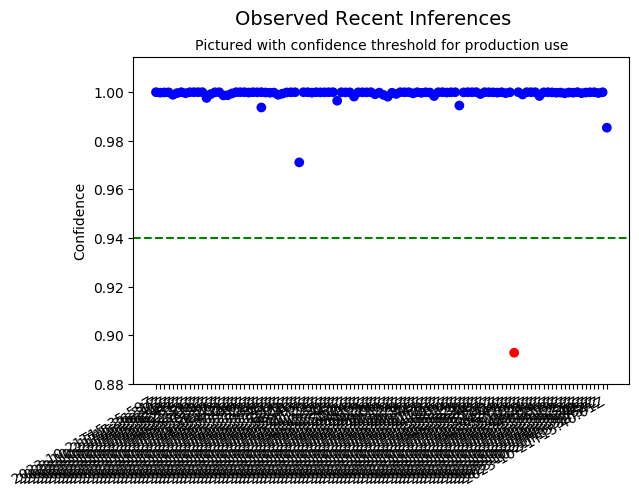

In [54]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


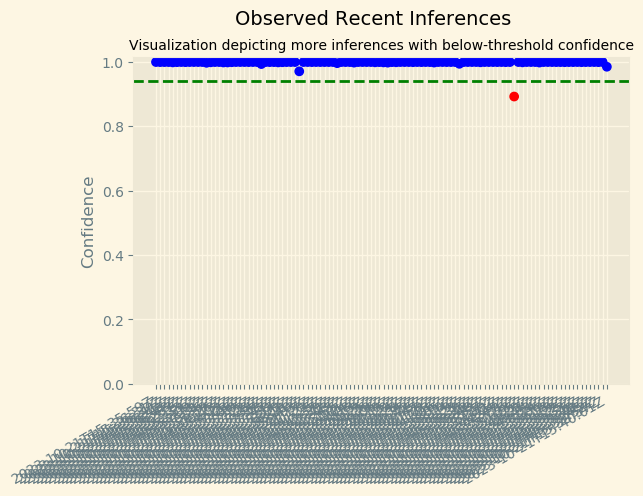

In [56]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=0)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Visualization depicting more inferences with below-threshold confidence", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.

As shown, the workflow can be easily extended to the entire CIFAR dataset. 
- The model is almost completely sure for the majority of images as can be seen in the two figures above.
- Only one image of the ones tested fell below the .94 confidence threshold.

However, there were some issues:
- The training took much longer.
- The endpoint was much slower in classifying images which in turn led to some of the Lambda invocations timing out and the overall Step Function execution failing.

Some considerations for if this were a production workload:
- Consider a different architecture and introduce an SQS queue to ensure every test case actually gets executed.
- Scale the endpoint so it can handle more inferences at once.



